# ATMS 523
## Module 4 Notebook 1
## Wrangling time series

### Combining datasets with pandas

Here we will load a variety of climate datasets, and use pandas to unify the datasets for further analysis.

In [102]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
enso = pd.read_csv('https://www.atmos.illinois.edu/~snesbitt/soi.dat',sep=r'\s+',header=None,skiprows=4,skipfooter=0, engine='python')
pdo = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat',sep=r'\s+',header=None,skiprows=2, engine='python')
nao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')
ao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')

Take a look at the dataframes, note how they are formatted and if there are any issues with the values (missing data, etc.).

In [103]:
enso


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1951,1.5,0.9,-0.1,-0.3,-0.7,0.2,-1.0,-0.2,-1.1,-1.0,-0.8,-0.7
1,1952,-0.9,-0.6,0.5,-0.2,0.8,0.7,0.5,0.1,-0.2,0.4,0.0,-1.2
2,1953,0.3,-0.5,-0.2,0.2,-1.7,0.1,-0.0,-1.2,-1.2,0.1,-0.3,-0.5
3,1954,0.7,-0.3,0.3,0.6,0.5,0.1,0.4,1.1,0.2,0.3,0.1,1.4
4,1955,-0.5,1.9,0.6,-0.1,1.0,1.3,1.6,1.5,1.3,1.5,1.2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2021,1.9,1.5,0.4,0.3,0.5,0.4,1.4,0.6,0.8,0.7,1.0,1.5
71,2022,0.5,1.1,1.8,1.7,1.4,1.7,0.8,1.0,1.6,1.7,0.3,2.1
72,2023,1.4,1.4,0.2,0.2,-1.0,0.3,-0.3,-0.8,-1.3,-0.5,-0.8,-0.2
73,2024,0.5,-1.4,0.4,-0.2,0.5,0.0,-0.7,0.9,-0.1,0.5,0.5,1.2


Now that we have read in the data, it's time to get them into a format that we can use with pandas.  Time series should be a single column, with a date column with a value of each index in each row.

We'll approach this by creating a new data frame and reformatting the 12 x nyears array to a 1 x nobservations array corresponding with each date.

Let's start with ENSO.

In [104]:
enso_new=pd.DataFrame()


In [105]:
enso_new

""


In [106]:
enso[0].iloc[-1]

np.int64(2025)

Let's create an ENSO 'Date' column that has a Datetime Index.  The pandas DatetimeIndex can be used to generate dates with a given frequency.

In [107]:
enso_new['Date']=pd.date_range(
    start=datetime.datetime(enso[0].iloc[0],1,1),
    end=datetime.datetime(enso[0].iloc[-1],12,1),
    freq="MS")

enso_new = enso_new.set_index('Date')

In [108]:
enso_new

""
Date
1951-01-01
1951-02-01
1951-03-01
1951-04-01
1951-05-01
...
2025-08-01
2025-09-01
2025-10-01


Now, let's stuff the data into our array.  We can use the stack() command to take the 2D array and create a 1D column.

In [109]:
len(enso.loc[:,1:].stack().values)

900

In [110]:
enso_new['ENSO']=enso.loc[:,1:].stack().values

How does it look?

In [111]:
enso_new

,ENSO
Date,
1951-01-01,1.5
1951-02-01,0.9
1951-03-01,-0.1
1951-04-01,-0.3
1951-05-01,-0.7
...,...
2025-08-01,0.4
2025-09-01,0.0
2025-10-01,-99.9


<Axes: xlabel='Date'>

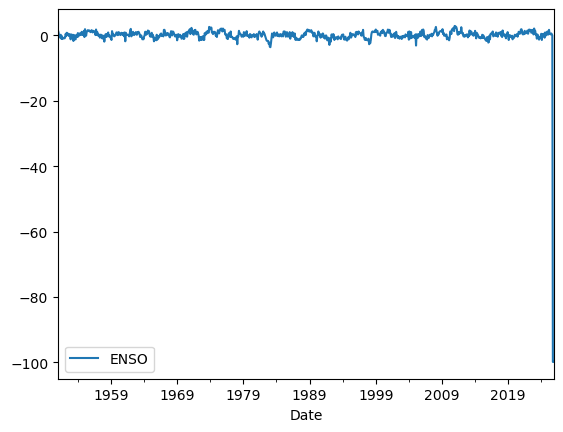

In [112]:
enso_new.plot()

## In-class exercise, do this for all of the 4 climate indicies.

Be sure to check the date ranges of your indicies by carefully inspecting the dataframes!

In [113]:
nao_new=pd.DataFrame()
pdo_new=pd.DataFrame()
ao_new=pd.DataFrame()

nao_new['Date'] = pd.date_range(start=datetime.datetime(nao[0].iloc[0],1,1),end=datetime.datetime(nao[0].iloc[-1],12,1),freq="MS")
pdo_new['Date'] = pd.date_range(start=datetime.datetime(pdo[0].iloc[0],1,1),end=datetime.datetime(pdo[0].iloc[-1],12,1),freq="MS")
ao_new['Date'] = pd.date_range(start=datetime.datetime(ao[0].iloc[0],1,1),end=datetime.datetime(ao[0].iloc[-1],12,1),freq="MS")

nao_new = nao_new.set_index('Date')
pdo_new = pdo_new.set_index('Date')
ao_new = ao_new.set_index('Date')

nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
ao_new['AO']=ao.loc[:,1:].stack(dropna=False).values

C:\Users\ztors\AppData\Local\Temp\ipykernel_21484\1740848809.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
C:\Users\ztors\AppData\Local\Temp\ipykernel_21484\1740848809.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
C:\Users\ztors\AppData\Local\Temp\ipykernel_21484\1740848809.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for detai

(586.0, 672.0)

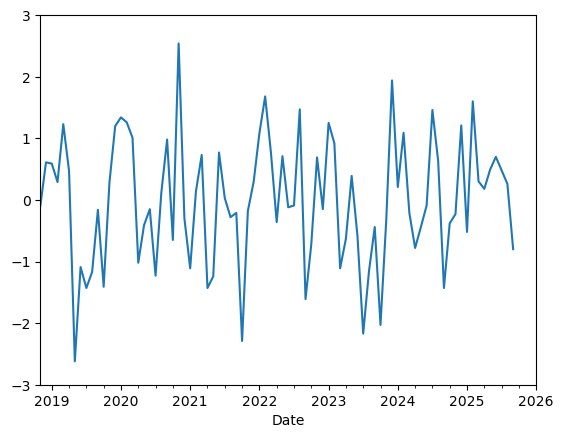

In [114]:
%matplotlib inline
nao_new['NAO'].plot()
plt.ylim([-3,3])
plt.xlim(['11-01-2018','01-01-2026'])

# Merging dataframes

Now that we have these indicies, we can join them together into one dataset.  We can use the pd.merge() command to do this for each of our dataframes one by one.  We need to tell pandas how to do the merge, and we do that by specifying the left_index and right_index, where left and right are the data frames given first and second in the pd.merge command.

In [115]:
newdf_all = pd.merge(enso_new,pdo_new, left_index=True, right_index=True)

In [116]:
newdf_all

,ENSO,PDO
Date,,
1951-01-01,1.5,-1.19
1951-02-01,0.9,-1.52
1951-03-01,-0.1,-1.72
1951-04-01,-0.3,-1.35
1951-05-01,-0.7,-1.29
...,...,...
2025-08-01,0.4,-3.18
2025-09-01,0.0,-2.38
2025-10-01,-99.9,99.99


<Axes: xlabel='Date'>

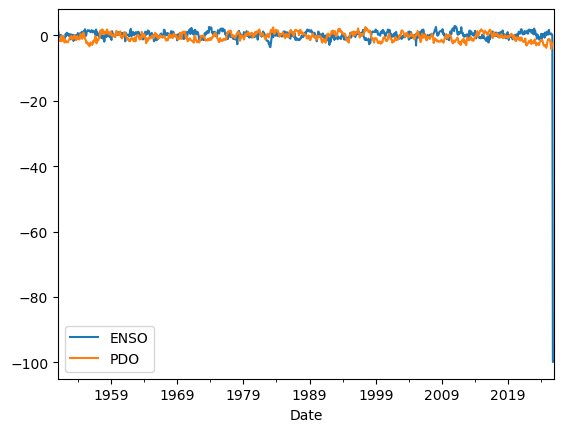

In [117]:
import numpy as np
newdf_all.loc[newdf_all['PDO'] > 90.,'PDO'] = np.nan
newdf_all.plot()

Rinse and repeat until all 4 columns are included in your new dataframe.

<Axes: xlabel='Date'>

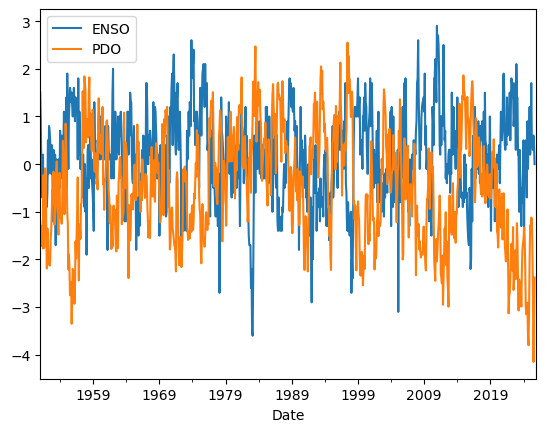

In [118]:
newdf_all.loc[newdf_all['ENSO'] <= -9.9,'ENSO'] = np.nan
newdf_all.plot()

In [119]:
newdf_all = pd.merge(newdf_all,nao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['NAO'] <= -99.9,'NAO'] = np.nan

<Axes: xlabel='Date'>

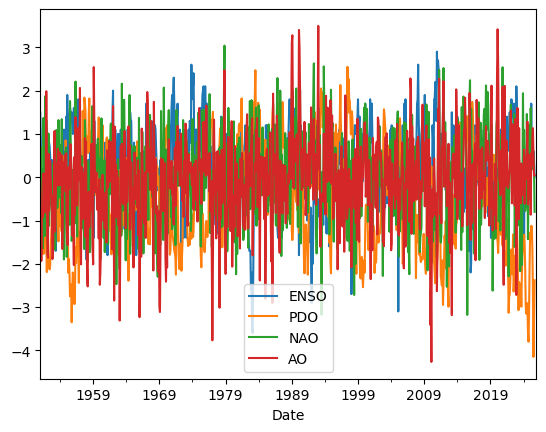

In [120]:
newdf_all = pd.merge(newdf_all,ao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['AO'] <= -99.9,'AO'] = np.nan

newdf_all.plot()

In [121]:
newdf_all

,ENSO,PDO,NAO,AO
Date,,,,
1951-01-01,1.5,-1.19,0.08,-0.085
1951-02-01,0.9,-1.52,0.70,-0.400
1951-03-01,-0.1,-1.72,-1.02,-1.934
1951-04-01,-0.3,-1.35,-0.22,-0.776
1951-05-01,-0.7,-1.29,-0.59,-0.863
...,...,...,...,...
2025-08-01,0.4,-3.18,0.26,0.036
2025-09-01,0.0,-2.38,-0.80,0.048
2025-10-01,NaN,NaN,NaN,NaN


Let's plot them against each other


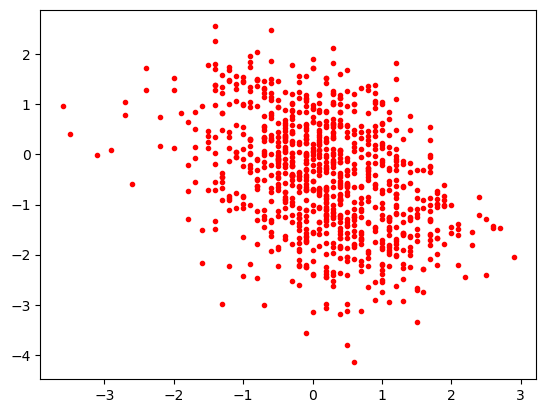

In [122]:

plt.plot(newdf_all['ENSO'].values,newdf_all['PDO'].values,'.r')

Or do it all together in one swoop.

Install the `seaborn` package for more visualiztion power!
[https://seaborn.pydata.org/]

```
mamba activate xarray-climate
mamba install -c conda-forge seaborn
```

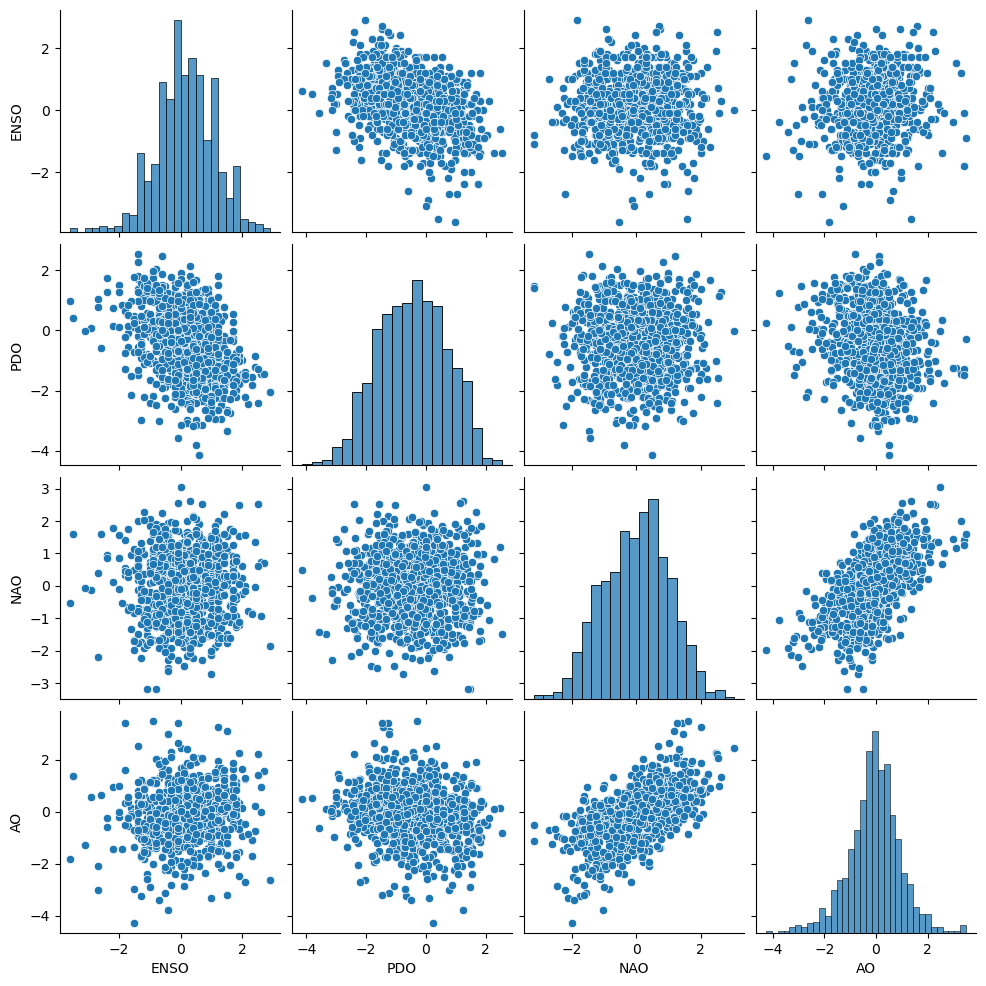

In [123]:
# Seaborn visualization library
import seaborn as sns
# Create the default pairplot
sns.pairplot(newdf_all)


Now let's bring in another dataset, the NASA GISS observed temperature record.  How does it match up with the climate indicies above?

In [124]:
import urllib.request
urllib.request.urlretrieve('https://data.giss.nasa.gov/pub/gistemp/gistemp250_GHCNv4.nc.gz', 'gistemp250_GHCNv4.nc.gz')

('gistemp250_GHCNv4.nc.gz', <http.client.HTTPMessage at 0x1d964a2de50>)

In [125]:
%matplotlib inline
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs

In [126]:
data = xr.open_dataset('gistemp250_GHCNv4.nc.gz')
data
   

<xarray.Dataset> Size: 113MB
Dimensions:      (time: 1748, nv: 2, lat: 90, lon: 180)
Coordinates:
  * lat          (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon          (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2025-08-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 28kB ...
    tempanomaly  (time, lat, lon) float32 113MB ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2025-09-10 02:53:53 by SBBX_to_nc 2.0 - ILAND=250, ...

Text(0.5, 1.0, 'GISTEMPv4 temperature trend (deg/year)')

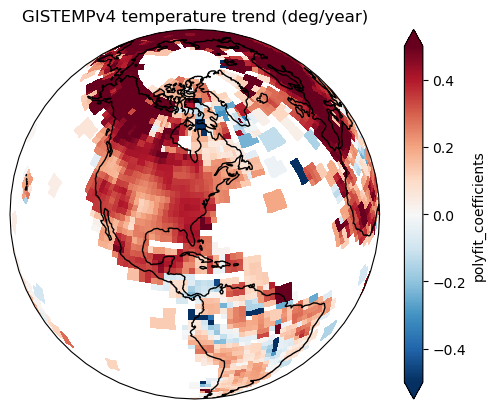

In [127]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
data['tempanomaly'].polyfit(dim='time',deg=1).isel(degree=1)['polyfit_coefficients'].plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap='RdBu_r')
ax.set_global(); ax.coastlines(); ax.set_title('GISTEMPv4 temperature trend (deg/year)')

Here we will introduce the sel command to find time and space subsets of our dataset.  Let's pull out the observed temperature trends at the point closest to Champaign-Urbana and examine the relationships with climate indicies.

In [128]:
temp = pd.DataFrame()

temp.index = data.time-pd.Timedelta(14, unit="D")
temp['obsT']=data['tempanomaly'].sel(lat=40.,lon=-88., method='nearest')

newdf_all = pd.merge(newdf_all,temp,left_index=True, right_index=True)


In [129]:
temp

,obsT
1880-01-01,9.24
1880-02-01,4.13
1880-03-01,0.34
1880-04-01,0.34
1880-05-01,3.48
...,...
2025-04-01,0.93
2025-05-01,-0.28
2025-06-01,1.92
2025-07-01,1.99


In [130]:
newdf_all

,ENSO,PDO,NAO,AO,obsT
1951-01-01,1.5,-1.19,0.08,-0.085,1.76
1951-02-01,0.9,-1.52,0.70,-0.400,0.47
1951-03-01,-0.1,-1.72,-1.02,-1.934,-0.55
1951-04-01,-0.3,-1.35,-0.22,-0.776,-1.72
1951-05-01,-0.7,-1.29,-0.59,-0.863,0.85
...,...,...,...,...,...
2025-04-01,0.5,-1.15,0.18,0.268,0.93
2025-05-01,0.4,-1.66,0.49,0.904,-0.28
2025-06-01,0.3,-2.62,0.70,1.134,1.92
2025-07-01,0.6,-4.15,0.48,0.500,1.99


Let's plot!

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\ztors\AppData\Local\Temp\ipykernel_21484\922028515.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('PiYG', 12)    # 11 discrete colors
C:\Users\ztors\AppData\Local\Temp\ipykernel_21484\922028515.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


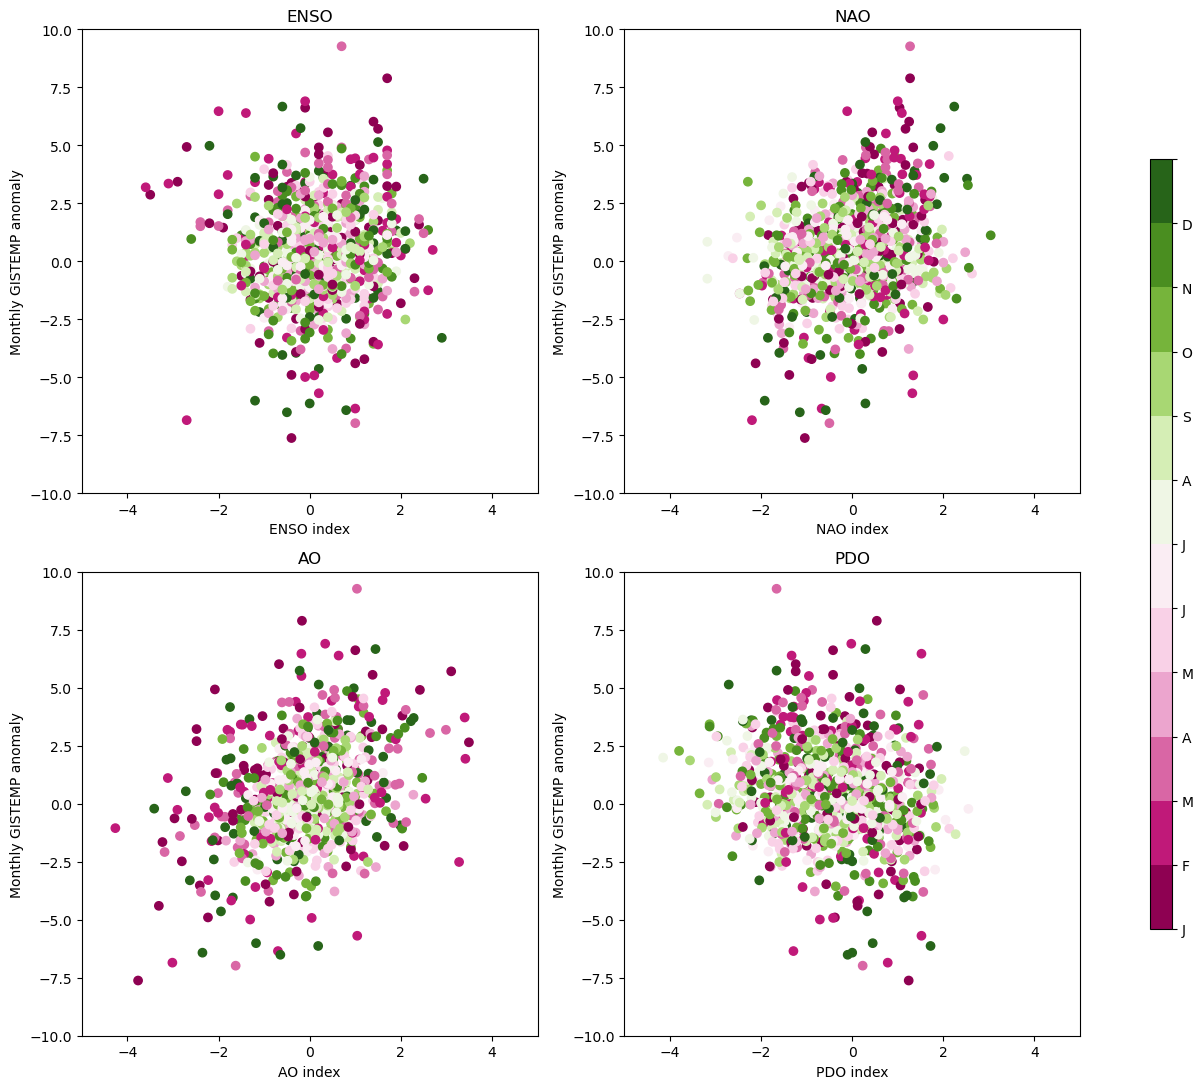

In [131]:
%pylab inline
import matplotlib as mpl

cmap = cm.get_cmap('PiYG', 12)    # 11 discrete colors
norm = mpl.colors.Normalize(vmin=1, vmax=13)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(11,11))

ax1.scatter(newdf_all['ENSO'].values,newdf_all['obsT'].values,c=newdf_all.index.month,cmap=cmap,norm=norm)
ax1.set_title('ENSO')
ax1.set_xlabel('ENSO index')
ax1.set_ylabel('Monthly GISTEMP anomaly')
ax1.set_ylim([-10,10])
ax1.set_xlim([-5,5])

ax2.scatter(newdf_all['NAO'].values,newdf_all['obsT'].values,c=newdf_all.index.month,cmap=cmap,norm=norm)
ax2.set_title('NAO')
ax2.set_xlabel('NAO index')
ax2.set_ylabel('Monthly GISTEMP anomaly')
ax2.set_ylim([-10,10])
ax2.set_xlim([-5,5])

ax3.scatter(newdf_all['AO'].values,newdf_all['obsT'].values,c=newdf_all.index.month,cmap=cmap,norm=norm)
ax3.set_title('AO')
ax3.set_xlabel('AO index')
ax3.set_ylabel('Monthly GISTEMP anomaly')
ax3.set_ylim([-10,10])
ax3.set_xlim([-5,5])


im=ax4.scatter(newdf_all['PDO'].values,newdf_all['obsT'].values,c=newdf_all.index.month,cmap=cmap,norm=norm)
ax4.set_title('PDO')
ax4.set_xlabel('PDO index')
ax4.set_ylabel('Monthly GISTEMP anomaly')
ax4.set_ylim([-10,10])
ax4.set_xlim([-5,5])

#fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.05, 0.15, 0.02, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax, ticks=1+np.arange(13), norm=norm)
cbar.ax.set_yticklabels(['J','F','M','A','M','J','J','A','S','O','N','D',' '])  # vertically oriented colorbar

plt.tight_layout()